<a href="https://colab.research.google.com/github/SirReinz/ENGGSCAI/blob/main/rpen0440ENGG2112SCAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import kagglehub
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

# for images
import tensorflow as tf
from tensorflow.keras import layers, models, applications

# for balancing
from sklearn.utils.class_weight import compute_class_weight

C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ISIC Data

In [2]:
# import datasets
ISIC = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
print(ISIC)


Resuming download from 402653184 bytes (421137475 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/nodoubttome/skin-cancer9-classesisic?dataset_version_number=1 (402653184/823790659) bytes left.


100%|██████████| 786M/786M [00:25<00:00, 16.2MB/s]

Extracting files...


C:\Users\richa\.cache\kagglehub\datasets\nodoubttome\skin-cancer9-classesisic\versions\1


In [6]:
def create_image_dataframe(dataset_path):
    """Create a DataFrame with image paths and labels from folder structure"""
    data = []

    for root, dirs, files in os.walk(dataset_path):
        # Skip the root directory
        if root == dataset_path:
            continue

        # Get class name from folder name
        class_name = os.path.basename(root)

        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                data.append({
                    'image_path': full_path,
                    'class': class_name,
                    'filename': file
                })

    return pd.DataFrame(data)

# Try to create DataFrame from folder structure
try:
    image_df = create_image_dataframe(ISIC)
    if not image_df.empty:
        print(f"Created image DataFrame: {image_df.shape}")
        print(f"Classes found: {image_df['class'].unique()}")
        print("\nSample data:")
        print(image_df.head())

        # Show class distribution
        print("\nClass distribution:")
        print(image_df['class'].value_counts())
except Exception as e:
    print(f"Could not create image DataFrame: {e}")

Created image DataFrame: (2357, 3)
Classes found: ['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'seborrheic keratosis'
 'squamous cell carcinoma' 'vascular lesion']

Sample data:
                                          image_path              class  \
0  C:\Users\richa\.cache\kagglehub\datasets\nodou...  actinic keratosis   
1  C:\Users\richa\.cache\kagglehub\datasets\nodou...  actinic keratosis   
2  C:\Users\richa\.cache\kagglehub\datasets\nodou...  actinic keratosis   
3  C:\Users\richa\.cache\kagglehub\datasets\nodou...  actinic keratosis   
4  C:\Users\richa\.cache\kagglehub\datasets\nodou...  actinic keratosis   

           filename  
0  ISIC_0010512.jpg  
1  ISIC_0010889.jpg  
2  ISIC_0024468.jpg  
3  ISIC_0024470.jpg  
4  ISIC_0024511.jpg  

Class distribution:
class
pigmented benign keratosis    478
melanoma                      454
basal cell carcinoma          392
nevus                         373
squamous ce

# SIIM ISIC Data

In [8]:
# Download the ISIC 2020 resized dataset (256x256)
ISIC_2020 = kagglehub.dataset_download("nischaydnk/isic-2020-jpg-256x256-resized")
print("ISIC 2020 (256x256) dataset downloaded to:", ISIC_2020)

Resuming download from 196083712 bytes (428094526 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/nischaydnk/isic-2020-jpg-256x256-resized?dataset_version_number=1 (196083712/624178238) bytes left.


100%|██████████| 595M/595M [00:28<00:00, 15.2MB/s]

Extracting files...


ISIC 2020 (256x256) dataset downloaded to: C:\Users\richa\.cache\kagglehub\datasets\nischaydnk\isic-2020-jpg-256x256-resized\versions\1


# PREPRCESSING RUN ALL

In [9]:
csv_files = []
for root, dirs, files in os.walk(ISIC_2020):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print("Found CSV files:")
for csv_file in csv_files:
    print(f"- {csv_file}")


# Load the CSV file into a new variable name to avoid conflict
if csv_files:
    metadata_df = pd.read_csv(csv_files[0]) # Keep metadata_df name for the ISIC_2020 metadata
    print(f"\nLoaded dataset shape: {metadata_df.shape}")
    print(f"Columns: {list(metadata_df.columns)}")
    print("\nFirst few rows:")
    print(metadata_df.head())
else:
    print("No CSV files found for ISIC 2020.")
    metadata_df = pd.DataFrame() # Create empty DataFrame if no CSV found


Found CSV files:
- C:\Users\richa\.cache\kagglehub\datasets\nischaydnk\isic-2020-jpg-256x256-resized\versions\1\train-metadata.csv

Loaded dataset shape: (33126, 4)
Columns: ['Unnamed: 0', 'isic_id', 'patient_id', 'target']

First few rows:
   Unnamed: 0       isic_id  patient_id  target
0           0  ISIC_2637011  IP_7279968       0
1           1  ISIC_0015719  IP_3075186       0
2           2  ISIC_0052212  IP_2842074       0
3           3  ISIC_0068279  IP_6890425       0
4           4  ISIC_0074268  IP_8723313       0


In [10]:
# Join the two datasets

# Define a mapping for the first dataset's classes to a binary target
class_to_target = {
    'nevus': 0,
    'seborrheic keratosis': 0,
    'pigmented benign keratosis': 0,
    'melanoma': 1,
    'basal cell carcinoma': 1,
    'actinic keratosis': 0, # Actinic keratosis is pre-malignant, but often treated as benign in datasets
    'vascular lesion': 0,
    'dermatofibroma': 0,
    'squamous cell carcinoma': 1
}

# Apply the mapping to the first dataset
# Ensure image_df from cell 1VvSVQBHh1m_ is used and it has the 'class' column
if 'class' in image_df.columns:
    image_df['target'] = image_df['class'].map(class_to_target)
    # Keep only relevant columns for merging and add source column
    image_df_subset = image_df[['image_path', 'target']].copy()
    image_df_subset.rename(columns={'target': 'label'}, inplace=True) # Rename to avoid confusion with the second dataset's 'target'
    image_df_subset['source'] = 'ISIC' # Add source column
else:
    # This case should ideally not happen if image_df from folder structure is used
    print("Error: 'class' column not found in the image_df from folder structure. Cannot create binary labels for merging.")
    # Create an empty DataFrame with the expected columns to avoid errors during concatenation
    image_df_subset = pd.DataFrame(columns=['image_path', 'label', 'source'])


# For the second dataset, we already have the 'target' column (0 or 1) in metadata_df
if 'target' in metadata_df.columns and 'isic_id' in metadata_df.columns:
    # Construct image paths using 'isic_id' and the base path of the ISIC 2020 dataset
    # --- Debug Print for ISIC_2020 Path ---
    print(f"\nDebug: ISIC_2020 path is: {ISIC_2020}")
    # --- End Debug Print ---
    metadata_df_subset = metadata_df[['isic_id', 'target']].copy()
    # Assuming images are in a 'train' subdir and are .jpg within the ISIC_2020 path
    metadata_df_subset['image_path'] = metadata_df_subset['isic_id'].apply(lambda x: os.path.join(ISIC_2020, 'train-image/image', x + '.jpg'))
    metadata_df_subset.rename(columns={'target': 'label'}, inplace=True) # Rename to match the first dataset subset
    metadata_df_subset = metadata_df_subset[['image_path', 'label']] # Reorder columns
    metadata_df_subset['source'] = 'ISIC_2020' # Add source column

else:
    print("Warning: 'target' or 'isic_id' column not found in the second dataset. Cannot use its labels for merging.")
    # Create an empty DataFrame with the expected columns to avoid errors during concatenation
    metadata_df_subset = pd.DataFrame(columns=['image_path', 'label', 'source'])

# --- Debugging Print Statements ---
print("\n--- Debug Info Before Concatenation ---")
print("image_df_subset shape:", image_df_subset.shape)
print("image_df_subset head:")
display(image_df_subset.head())
print("\nmetadata_df_subset shape:", metadata_df_subset.shape)
print("metadata_df_subset head:")
display(metadata_df_subset.head())
print("--- End Debug Info ---")
# --- End Debugging Print Statements ---


# Concatenate the two dataframes
# Ensure both dataframes have the 'image_path', 'label', and 'source' columns before concatenating
combined_df = pd.concat([image_df_subset, metadata_df_subset], ignore_index=True)

# Drop rows where 'label' is NaN to ensure no missing labels
combined_df.dropna(subset=['label'], inplace=True)

print("Combined DataFrame shape:", combined_df.shape)
print("Combined DataFrame head:")
display(combined_df.head())

# Display class distribution in the combined dataset
print("\nClass distribution in combined dataset:")
print(combined_df['label'].value_counts())

# You can now use 'combined_df' for further preprocessing and model training


Debug: ISIC_2020 path is: C:\Users\richa\.cache\kagglehub\datasets\nischaydnk\isic-2020-jpg-256x256-resized\versions\1

--- Debug Info Before Concatenation ---
image_df_subset shape: (2357, 3)
image_df_subset head:


,image_path,label,source
0,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
1,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
2,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
3,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
4,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC



metadata_df_subset shape: (33126, 3)
metadata_df_subset head:


,image_path,label,source
0,C:\Users\richa\.cache\kagglehub\datasets\nisch...,0,ISIC_2020
1,C:\Users\richa\.cache\kagglehub\datasets\nisch...,0,ISIC_2020
2,C:\Users\richa\.cache\kagglehub\datasets\nisch...,0,ISIC_2020
3,C:\Users\richa\.cache\kagglehub\datasets\nisch...,0,ISIC_2020
4,C:\Users\richa\.cache\kagglehub\datasets\nisch...,0,ISIC_2020


--- End Debug Info ---
Combined DataFrame shape: (35483, 3)
Combined DataFrame head:


,image_path,label,source
0,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
1,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
2,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
3,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC
4,C:\Users\richa\.cache\kagglehub\datasets\nodou...,0,ISIC



Class distribution in combined dataset:
label
0    33856
1     1627
Name: count, dtype: int64


In [11]:
import tensorflow as tf
import os

# 0 = Benign, 1 = Malignant

# Preprocessing

# Split the data into training and validation sets using the combined_df
train_df, val_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label'], random_state=42)

# Define image size
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Function to load and preprocess images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # Decode JPG image
    img = tf.image.convert_image_dtype(img, tf.float32) # Convert to float [0, 1]
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) # Resize image
    return img, label

# Create tf.data.Dataset from dataframes
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_df['label']))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'], val_df['label']))

# Apply the loading and preprocessing function to the datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
BATCH_SIZE = 32

train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


# Balance dataset (calculate class weights based on the combined training data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

Class weights: {0: np.float64(0.5240363314133806), 1: np.float64(10.900921658986174)}


In [12]:
def load_and_preprocess_image_for_cnn(row, target_size=(256, 256)):
    """Loads, decodes, and preprocesses an image for CNN input based on source."""
    image_path = row['image_path']
    source = row['source']

    # Determine the correct base path based on the source
    if source == 'ISIC':
        base_path = ISIC
    elif source == 'ISIC_2020':
        base_path = ISIC_2020
    else:
        print(f"Warning: Unknown source '{source}' for image '{image_path}'. Cannot load.")
        return None

    # Construct the full image path
    full_image_path = os.path.join(base_path, os.path.basename(image_path))


    try:
        img = Image.open(full_image_path).convert('RGB')  # Ensure image is in RGB format
        img = img.resize(target_size)
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}")
        return None

# Define the target size for the images
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [13]:
# Use combined_df for splitting
X = combined_df['image_path']
y = combined_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 24838
Testing set size: 10645


# PREPROCESSING END

In [14]:
import os

# Check if image files in train_df exist
print("Checking if image files in the training dataset exist...")
all_files_exist = True
checked_count = 0
for image_path in train_df['image_path']:
    if not os.path.exists(image_path):
        all_files_exist = False
        # Stop after finding a few missing files to avoid excessive output
        checked_count += 1
        if checked_count <= 5:
            print(f"Image file not found: {image_path}")

if all_files_exist:
    print("All checked image files in the training dataset exist.")
elif checked_count > 0:
    print("Some image files were not found. Please check the paths.")
else:
    print("No image files to check in the training dataset.")

Checking if image files in the training dataset exist...
All checked image files in the training dataset exist.


# DenseNet121

In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import Precision, Recall

# Load pretrained DenseNet121 from ImageNet
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,      # exclude the final classification layer
    input_shape=(256, 256, 3)
)

# Freeze base model so its weights aren’t updated yet
base_model.trainable = False
# this pretrained model already recognised edges etc, thus freezing for the start is good

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [16]:
model = models.Sequential([
    base_model,  # DenseNet feature extractor
    layers.GlobalAveragePooling2D(),  # reduces spatial dimensions
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary classification output
])


In [17]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
)

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,
    class_weight=class_weights,
    callbacks=[checkpoint_cb]
)


Epoch 1/7
888/888 ━━━━━━━━━━━━━━━━━━━━ 957s 1s/step - accuracy: 0.8272 - auc: 0.8985 - loss: 0.4034 - precision: 0.1837 - recall: 0.8041 - val_accuracy: 0.8108 - val_auc: 0.9030 - val_loss: 0.4503 - val_precision: 0.1750 - val_recall: 0.8431
Epoch 2/7
888/888 ━━━━━━━━━━━━━━━━━━━━ 849s 955ms/step - accuracy: 0.8304 - auc: 0.9019 - loss: 0.3962 - precision: 0.1869 - recall: 0.8049 - val_accuracy: 0.7552 - val_auc: 0.9073 - val_loss: 0.5341 - val_precision: 0.1442 - val_recall: 0.8800
Epoch 3/7
888/888 ━━━━━━━━━━━━━━━━━━━━ 839s 944ms/step - accuracy: 0.8341 - auc: 0.9057 - loss: 0.3896 - precision: 0.1897 - recall: 0.7995 - val_accuracy: 0.7953 - val_auc: 0.9085 - val_loss: 0.4681 - val_precision: 0.1647 - val_recall: 0.8523
Epoch 4/7
888/888 ━━━━━━━━━━━━━━━━━━━━ 846s 951ms/step - accuracy: 0.8350 - auc: 0.9090 - loss: 0.3826 - precision: 0.1924 - recall: 0.8126 - val_accuracy: 0.8492 - val_auc: 0.9050 - val_loss: 0.3719 - val_precision: 0.2060 - val_recall: 0.8031
Epoch 5/7
888/888 ━━━━━

In [24]:
model.save('skin_cancer_classifier_model.keras')

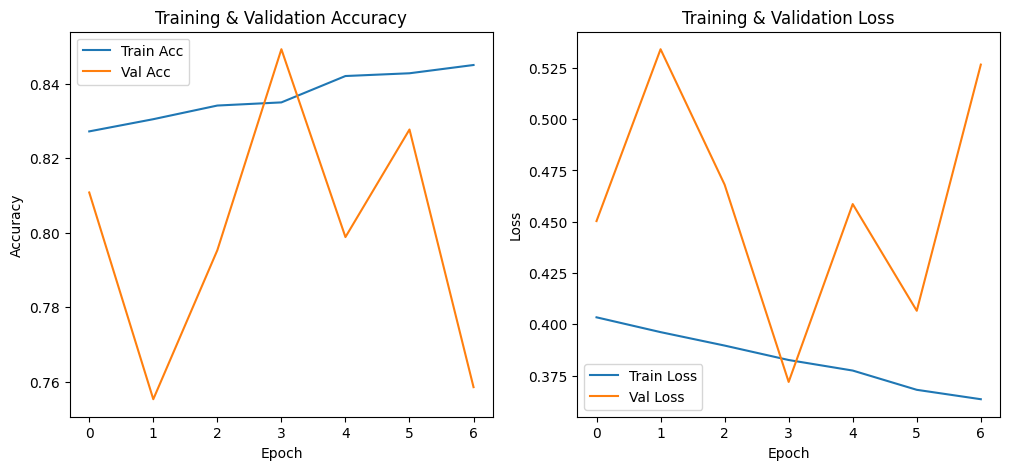

In [26]:
# --- Plot results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()